# EDA and feature engineering

In [64]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
import json
import seaborn as sns

import plotly.express as px
import matplotlib.pylab as plt
plt.style.use('ggplot')

def root_mean_squared_log_error(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all() 
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5

In [2]:
# Reading the datasets
# train
train_apartment = pd.read_csv('../data/apartments_train.csv')
train_building = pd.read_csv('../data/buildings_train.csv')
df_train = pd.merge(train_apartment, train_building.set_index('id'), how='left', left_on='building_id', right_on='id')

# test
test_apartment = pd.read_csv('../data/apartments_test.csv')
test_building = pd.read_csv('../data/buildings_test.csv')
df_test = pd.merge(test_apartment, test_building.set_index('id'), how='left', left_on='building_id', right_on='id')

df_all = pd.concat([df_train, df_test])
df_all['Split'] = np.where(df_all['id'] <= np.max(df_train['id']), 'Train', 'Test')

In [3]:
df_all

id  seller       price  area_total  area_kitchen  area_living  floor  \
0         0     3.0   7139520.0        59.2          12.5         31.0    2.0   
1         1     NaN  10500000.0        88.0          14.2         48.0   18.0   
2         2     3.0   9019650.0        78.5          22.5         40.8   12.0   
3         3     NaN  10500000.0        88.0          14.0         48.0   18.0   
4         4     NaN  13900000.0        78.0          17.0         35.0    7.0   
...     ...     ...         ...         ...           ...          ...    ...   
9932  33217     3.0         NaN       106.0          19.9         56.7   16.0   
9933  33218     NaN         NaN        82.0           NaN          NaN    3.0   
9934  33219     NaN         NaN        49.3           NaN          NaN   15.0   
9935  33220     NaN         NaN        38.8          10.5         15.1   14.0   
9936  33221     1.0         NaN        71.5           7.0         49.0    2.0   

      rooms  layout  ceiling  ...  constructed  material  stories  \
0       2.0     NaN     2.65  ...       2021.0       3.0      9.0   
1       3.0     1.0      NaN  ...       2010.0       3.0     25.0   
2       3.0     NaN     2.65  ...       2021.0       3.0     15.0   
3       3.0     NaN      NaN  ...       2010.0       3.0     25.0   
4       2.0     1.0     2.90  ...       2017.0       2.0     15.0   
...     ...     ...      ...  ...          ...       ...      ...   
9932    3.0     NaN     3.30  ...       2020.0       2.0     20.0   
9933    3.0     NaN      NaN  ...       2021.0       2.0     20.0   
9934    1.0     NaN     0.00  ...       2016.0       2.0     24.0   
9935    1.0     NaN     3.30  ...       2019.0       NaN     14.0   
9936    3.0     NaN      NaN  ...          NaN       NaN      2.0   

      elevator_without  elevator_passenger  elevator_service  parking  \
0                  0.0                 1.0               1.0      1.0   
1                  0.0                 1.0               1.0      1.0   
2                  0.0                 1.0               1.0      1.0   
3                  0.0                 1.0               1.0      1.0   
4                  0.0                 1.0               1.0      1.0   
...                ...                 ...               ...      ...   
9932               0.0                 1.0               1.0      0.0   
9933               0.0                 1.0               1.0      1.0   
9934               0.0                 1.0               1.0      0.0   
9935               1.0                 1.0               1.0      0.0   
9936               NaN                 NaN               NaN      NaN   

      garbage_chute  heating  Split  
0               NaN      NaN  Train  
1               NaN      0.0  Train  
2               NaN      NaN  Train  
3               NaN      0.0  Train  
4               0.0      0.0  Train  
...             ...      ...    ...  
9932            NaN      0.0   Test  
9933            NaN      NaN   Test  
9934            1.0      1.0   Test  
9935            1.0      NaN   Test  
9936            NaN      NaN   Test  

[33222 rows x 35 columns]

In [4]:
print('Number of Training Examples = {}'.format(df_train.shape[0]))
print('Number of Test Examples = {}\n'.format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}\n'.format(df_train['price'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}\n'.format(df_test.shape[0]))
print('Train columns \n', list(df_train.columns))
print('Test columns \n', list(df_test.columns))

Number of Training Examples = 23285
Number of Test Examples = 9937

Training X Shape = (23285, 34)
Training y Shape = 23285

Test X Shape = (9937, 33)
Test y Shape = 9937

Train columns 
 ['id', 'seller', 'price', 'area_total', 'area_kitchen', 'area_living', 'floor', 'rooms', 'layout', 'ceiling', 'bathrooms_shared', 'bathrooms_private', 'windows_court', 'windows_street', 'balconies', 'loggias', 'condition', 'phones', 'building_id', 'new', 'latitude', 'longitude', 'district', 'street', 'address', 'constructed', 'material', 'stories', 'elevator_without', 'elevator_passenger', 'elevator_service', 'parking', 'garbage_chute', 'heating']
Test columns 
 ['id', 'seller', 'area_total', 'area_kitchen', 'area_living', 'floor', 'rooms', 'layout', 'ceiling', 'bathrooms_shared', 'bathrooms_private', 'windows_court', 'windows_street', 'balconies', 'loggias', 'condition', 'phones', 'building_id', 'new', 'latitude', 'longitude', 'district', 'street', 'address', 'constructed', 'material', 'stories', 'el

In [5]:
def describe_column(meta):
    """
    Utility function for describing a dataset column (see below for usage)
    """
    def f(x):
        d = pd.Series(name=x.name, dtype=object)
        m = next(m for m in meta if m['name'] == x.name)
        d['Type'] = m['type']
        d['#NaN'] = x.isna().sum()
        d['Description'] = m['desc']
        if m['type'] == 'categorical':
            counts = x.dropna().map(dict(enumerate(m['cats']))).value_counts().sort_index()
            d['Statistics'] = ', '.join(f'{c}({n})' for c, n in counts.items())
        elif m['type'] == 'real' or m['type'] == 'integer':
            stats = x.dropna().agg(['mean', 'std', 'min', 'max'])
            d['Statistics'] = ', '.join(f'{s}={v :.1f}' for s, v in stats.items())
        elif m['type'] == 'boolean':
            counts = x.dropna().astype(bool).value_counts().sort_index()
            d['Statistics'] = ', '.join(f'{c}({n})' for c, n in counts.items())
        else:
            d['Statistics'] = f'#unique={x.nunique()}'
        return d
    return f

def describe_data(data, meta):
    desc = data.apply(describe_column(meta)).T
    desc = desc.style.set_properties(**{'text-align': 'left'})
    desc = desc.set_table_styles([ dict(selector='th', props=[('text-align', 'left')])])
    return desc 

## Apartments

In [6]:
print(f'Loaded {len(train_apartment)} apartments')
with open('../data/apartments_meta.json') as f: 
    apartments_meta = json.load(f)
describe_data(train_apartment, apartments_meta)

Loaded 23285 apartments


## Buildings

In [7]:
print(f'Loaded {len(train_building)} buildings')
with open('../data/buildings_meta.json') as f: 
    buildings_meta = json.load(f)
train_building.head()
describe_data(train_building, buildings_meta)

Loaded 6791 buildings


## Price distribution

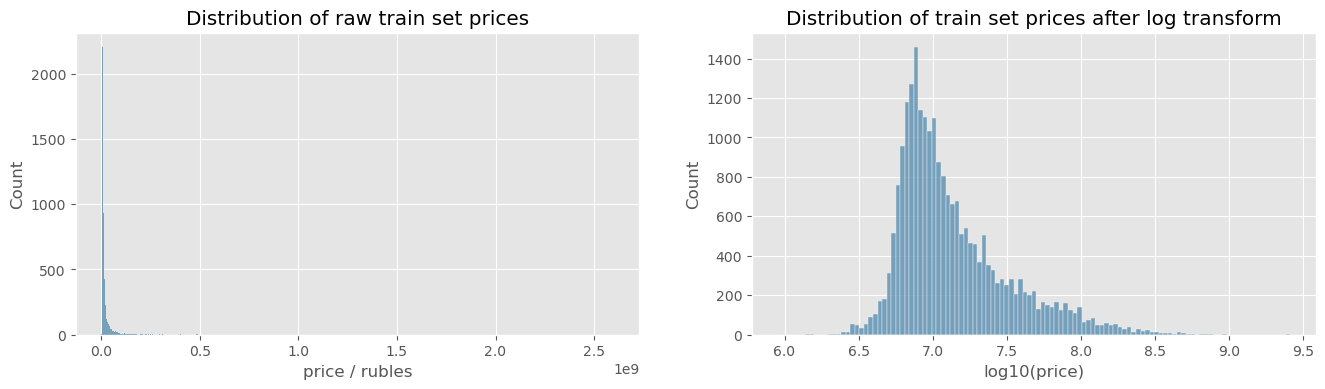

In [45]:
fig, (ax1, ax2) = plt.subplots(figsize=(16, 4), ncols=2, dpi=100)
sns.histplot(df_train.price.rename('price / rubles'), ax=ax1)
ax1.set_title('Distribution of raw train set prices');
sns.histplot(np.log10(df_train.price).rename('log10(price)'), ax=ax2)
ax2.set_title('Distribution of train set prices after log transform');
# df_all = df_all.fillna(df_all.mean())

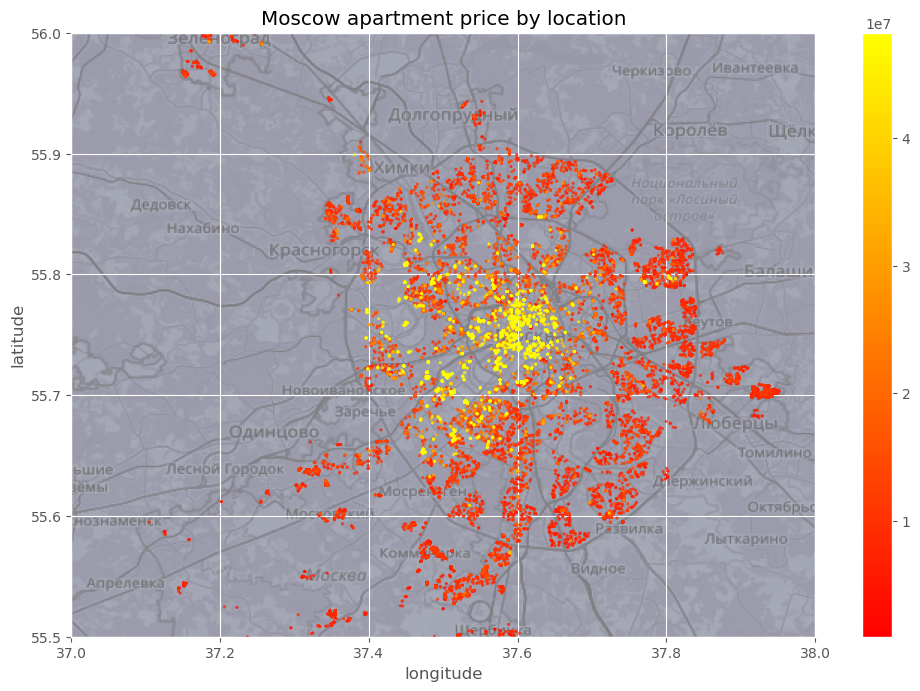

In [46]:
def plot_map(data, ax=None, s=5, a=0.75, q_lo=0.0, q_hi=0.9, cmap='autumn', column='price', title='Moscow apartment price by location'):
    data = data[['latitude', 'longitude', column]].sort_values(by=column, ascending=True)
    backdrop = plt.imread('../data/moscow.png')
    backdrop = np.einsum('hwc, c -> hw', backdrop, [0, 1, 0, 0]) ** 2
    if ax is None:
        plt.figure(figsize=(12, 8), dpi=100)
        ax = plt.gca()
    discrete = data[column].nunique() <= 20
    if not discrete:
        lo, hi = data[column].quantile([q_lo, q_hi])
        hue_norm = plt.Normalize(lo, hi)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(lo, hi))
        sm.set_array([])
    else:
        hue_norm = None 
    ax.imshow(backdrop, alpha=0.5, extent=[37, 38, 55.5, 56], aspect='auto', cmap='bone', norm=plt.Normalize(0.0, 2))
    sns.scatterplot(x='longitude', y='latitude', hue=data[column].tolist(), ax=ax, s=s, alpha=a, palette=cmap,linewidth=0, hue_norm=hue_norm, data=data)
    ax.set_xlim(37, 38)    # min/max longitude of image 
    ax.set_ylim(55.5, 56)  # min/max latitude of image
    if not discrete:
        ax.legend().remove()
        ax.figure.colorbar(sm)
    ax.set_title(title)
    return ax, hue_norm

plot_map(df_train);

In [48]:
# from folium import Choropleth, Circle, Marker
# from folium.plugins import HeatMap, MarkerCluster
# import math

# def preprocess(df) :
#     df = df[['district','latitude','longitude','price']]
#     df = df.replace('NA', np.nan)
#     df.dropna(subset=['latitude'], inplace=True)
#     df.dropna(subset=['price'], inplace=True)
#     df["latitude"] = df["latitude"].astype(float)
#     df["longitude"] = df["longitude"].astype(float)
#     return df

# map1_df = preprocess(df_train)

# city_map = folium.Map(location=[55.75,37.62], zoom_start=11.2, tiles='Stamen Terrain')
# mc = MarkerCluster()
# for idx, row in map1_df.iterrows():
#     if not math.isnan(row['longitude']) and not math.isnan(row['latitude']):
#         popup = """
#         District : <b>%s</b><br>
#         Price : <b>%s</b><br>
#         """ % (row['district'], row['price'])
#         mc.add_child(Marker([row['latitude'], row['longitude']],tooltip=popup))
#     city_map.add_child(mc)
# city_map

## Missing values

Number of missing price entries in train data: 0
Training set features with any missing value: 23/34
Testing set features with any missing value: 25/33
['id', 'price', 'area_total', 'floor', 'rooms', 'building_id', 'latitude', 'longitude', 'street', 'address', 'stories']


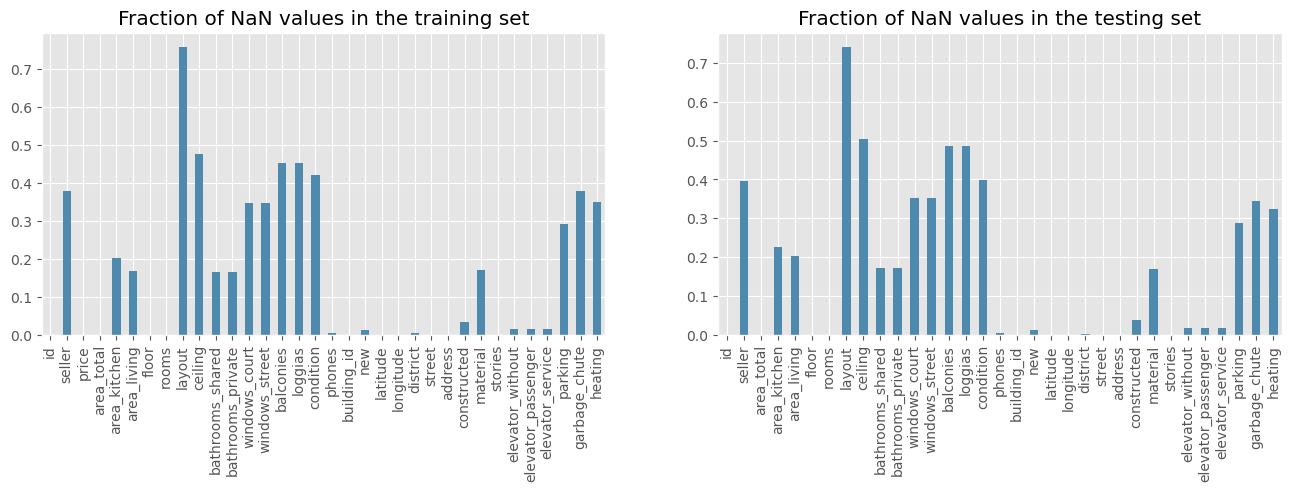

In [37]:
fig, (ax1, ax2) = plt.subplots(figsize=(16, 4), ncols=2, dpi=100)
print(f'Number of missing price entries in train data: {df_train.price.isna().sum()}')
print(f'Training set features with any missing value: {df_train.isna().any().sum()}/{df_train.shape[1]}')
print(f'Testing set features with any missing value: {df_test.isna().any().sum()}/{df_test.shape[1]}')
df_train.isna().mean().plot.bar(ax=ax1, title='Fraction of NaN values in the training set')
df_test.isna().mean().plot.bar(ax=ax2, title='Fraction of NaN values in the testing set');

featuresNA = dict(df_train.isna().any())
featuresNoNA = []
for key in featuresNA.keys():
    if not featuresNA[key] : featuresNoNA.append(key)
print(featuresNoNA)
#print(~df_train.isna().all())

## Feature engineering

### Individual features

In [49]:
def cat_plot(data,title,p):
    sns.catplot(x="rooms", y="price", data=data,palette = p)
    plt.title('No. of Bedrooms vs Price in '+ title,size=16)
    plt.gcf().set_size_inches(6,8)
    plt.show()

Nb of ouliers removed : 9


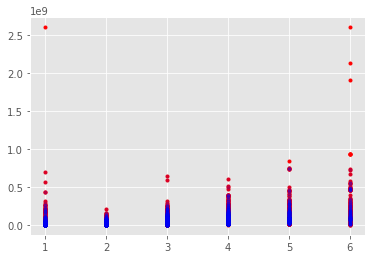

In [50]:
custom_colors = ["#4e89ae", "#c56183","#ed6663","#ffa372"]
customPalette = sns.set_palette(sns.color_palette(custom_colors))
moscow = sns.dark_palette(custom_colors[0], reverse=True)
outlier_value = 15
df_train_no_outliers = df_train[(np.abs(stats.zscore(df_train[["rooms", "price"]], axis=0, ddof=0)) < outlier_value).all(axis=1)]
print(f'Nb of ouliers removed : {df_train.shape[0]-df_train_no_outliers.shape[0]}')

plt.plot(df_train['rooms'], df_train['price'], 'r.')
plt.plot(df_train_no_outliers['rooms'], df_train_no_outliers['price'], 'b.', alpha=0.1)
#plt.xscale("log")
#plt.yscale("log")
plt.show()

### Feature correlation

Text(0.5, 1.0, 'Correlations all data')

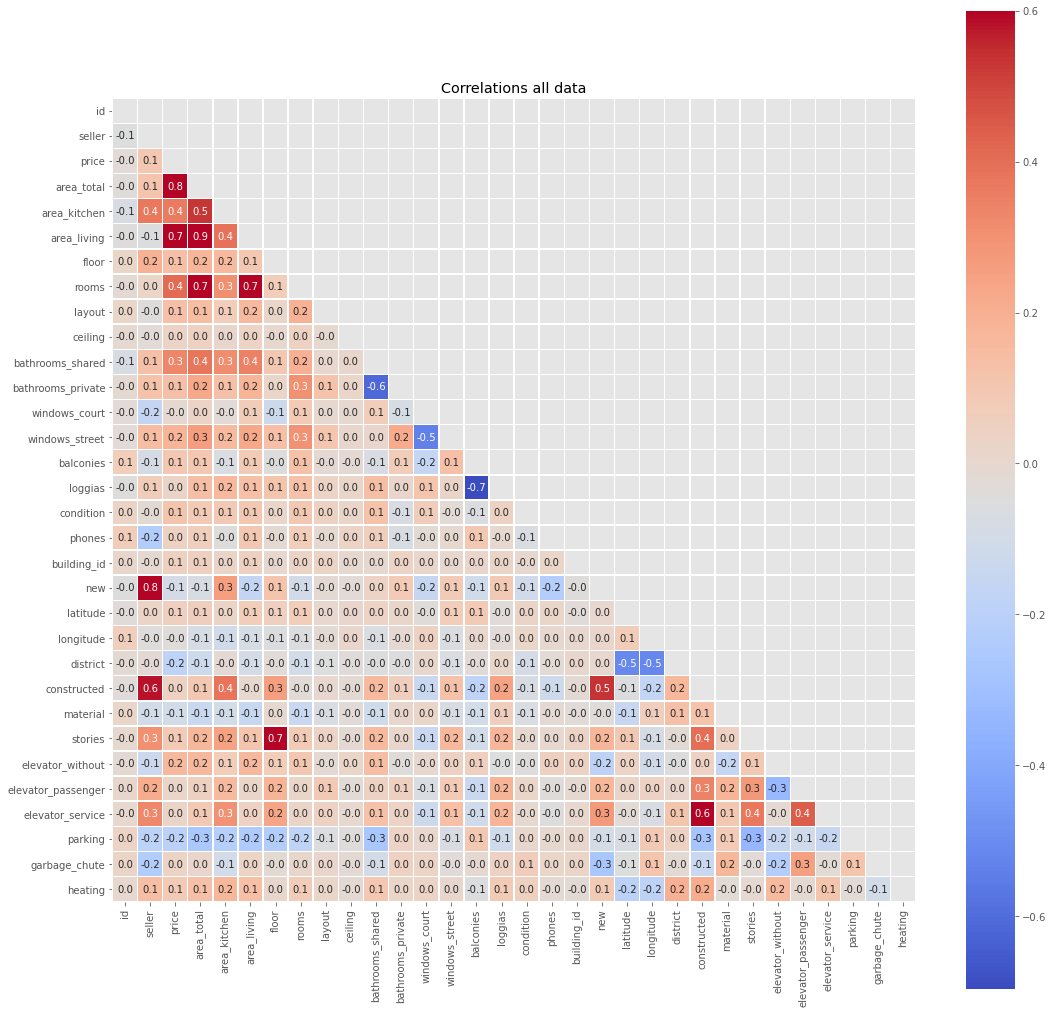

In [51]:
corr = df_train.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(df_train.corr(), mask=mask, vmax=0.6, square=True, cmap='coolwarm', annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.title('Correlations all data')

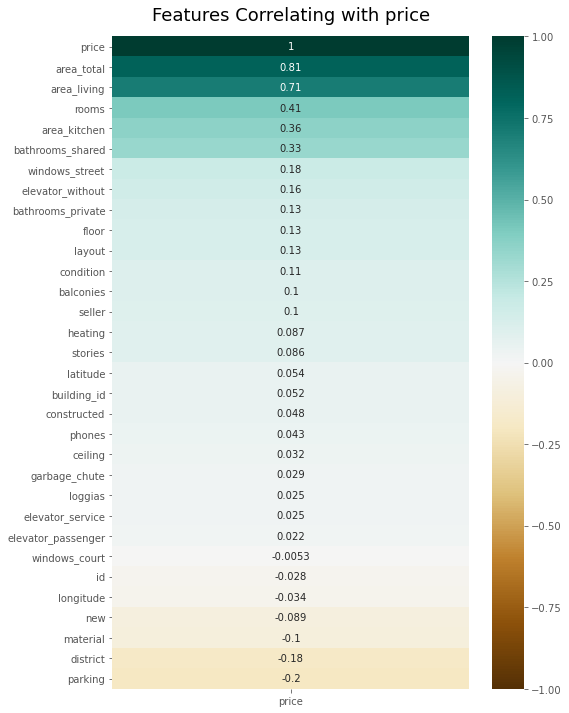

In [52]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df_train.corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with price', fontdict={'fontsize':18}, pad=16);

The features area_total and rooms have no missing values and corrolate strongly with the price. These will be the main features.

### Missing values of bathrooms_shared

Features that we can use to fill missing values :

In [53]:
featuresNoNA

['id',
 'price',
 'area_total',
 'floor',
 'rooms',
 'building_id',
 'latitude',
 'longitude',
 'street',
 'address',
 'stories']

C:\Users\Laure\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


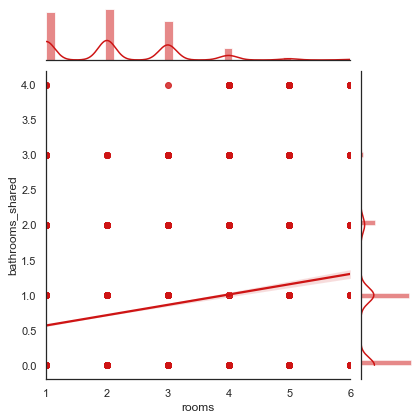

In [58]:
sns.jointplot(df_train.loc[:,'rooms'], df_train.loc[:,'bathrooms_shared'], kind="reg", color="#ce1414")

This feature is probably best to fill with the feature rooms even though it is not perfect.

### Corrolation between area_total, area_living and area_kitchen

C:\Users\Laure\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


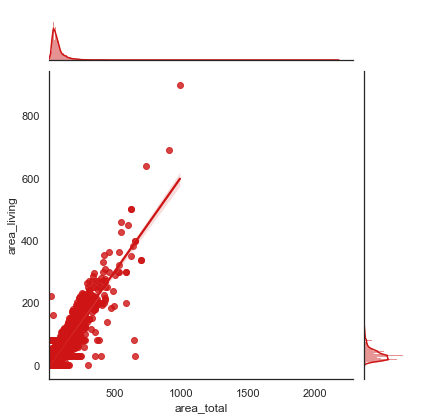

In [60]:
sns.jointplot(df_train.loc[:,'area_total'], df_train.loc[:,'area_living'], kind="reg", color="#ce1414")

There is a clear link between area_total and area_living is very clear. So we can use area_total to complete area_living.

In [1]:
fig = px.scatter_3d(df_train, x='area_kitchen', y='area_total', z='area_living',
              color='area_kitchen')
fig.show()

NameError: name 'px' is not defined

We can clearly see a plane between those three features. We can then deduce the missing values of the feature area_kitchen with the values of the features area_total and area_living.

### Missing values of ceiling

C:\Users\Laure\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



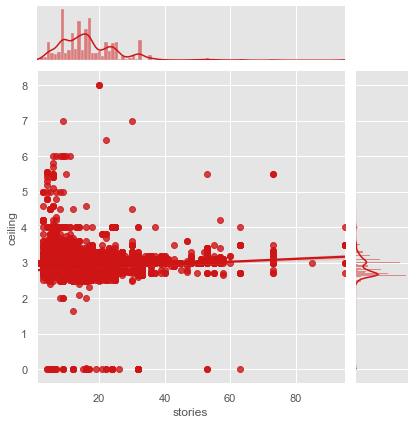

In [78]:
df_temp = df_train[df_train['ceiling'] < 20]
sns.jointplot(df_temp.loc[:,'stories'], df_temp.loc[:,'ceiling'], kind="reg", color="#ce1414")

We can see that when removing the outliers of the feature ceiling (value >= 20), there is a slight correlation with the feature stories. We can use this correlation to fill the missing values of the feature ceiling.

### Missing values of district

In [92]:
fig = px.scatter_3d(df_train, x='district', y='latitude', z='longitude',
              color='district')
fig.show()

The few missing values of the feature district can perhaps be deduced from latitude and longitude.

### Misssing values of parking

In [102]:
ft_temp = df_train.dropna()
fig = px.scatter_3d(df_temp, x='parking', y='stories', z='constructed',
              color='parking')
fig.show()

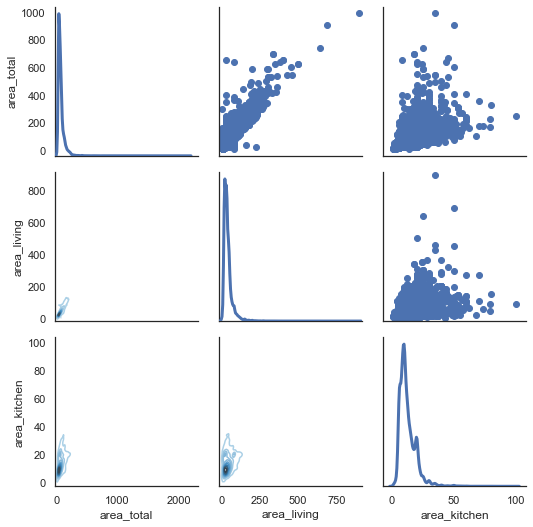

In [59]:
sns.set(style="white")
df = df_train.loc[:,['area_total','area_living','area_kitchen']]
g = sns.PairGrid(df, diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)